# Imports

In [1]:
import torch
from torch import nn

In [2]:
from torchvision.datasets import MNIST, SVHN
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Resize, Compose, Grayscale

In [3]:
from collections import defaultdict

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Functions

In [5]:
def get_corrects(preds, labels):
    class_num_pred = preds.argmax(dim=1)
    return sum(class_num_pred==labels).item()

# Load Dataset

In [6]:
batch_size = 16
transform = Compose([Resize((28,28)), ToTensor()])

source_loader = dict()
source_loader['train'] = DataLoader(MNIST('../datasets/',train=True, download = True, transform=transform), 
                                    batch_size=batch_size, shuffle=True)
source_loader['test'] = DataLoader(MNIST('../datasets/',train=False, download = True, transform=transform),
                                   batch_size=batch_size, shuffle=True)

target_loader = dict()
target_loader['train'] = DataLoader(SVHN('../datasets/', 'train', download = True, transform=transform),
                                    batch_size=batch_size, shuffle=True)
target_loader['test'] = DataLoader(SVHN('../datasets/','test', download = True, transform=transform),
                                   batch_size=batch_size, shuffle=True)

Using downloaded and verified file: ../datasets/train_32x32.mat
Using downloaded and verified file: ../datasets/test_32x32.mat


# Define Model

In [7]:
class VisionNet(nn.Module):
    def __init__(self, num_classes : int, conv_channels: int =20):
        super().__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3, conv_channels, 3)
        self.bn1 = nn.BatchNorm2d(conv_channels)
        self.conv2 = nn.Conv2d(conv_channels, 2*conv_channels, 3)
        self.bn2 = nn.BatchNorm2d(2*conv_channels)
        self.fc1 = nn.Linear(23040,100)
        self.fc2 = nn.Linear(100,num_classes)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
    def forward(self,x):
        if x.shape[1] == 1:
            x = x.repeat(1,3,1,1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.flat(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return x      



In [8]:
accs = defaultdict(list)

# Train On Source

In [9]:
model = VisionNet(num_classes = 10)
epochs = 10
criteria = nn.CrossEntropyLoss(reduce='mean')
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9)


for epoch in range(epochs):
    model.train()
    running_loss, corrects, count = 0.0, 0, 0
    for X,y in source_loader['train']:
        preds = model(X)
        loss = criteria(preds, y)
        running_loss += loss.item()
        corrects += get_corrects(preds, y)
        count += X.shape[0]
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    msg = 'Epoch: %d, Source Train Loss: %0.2f, Acc: %0.2f' % (epoch, running_loss, corrects/count)
    
    model.eval()
    running_loss, corrects, count = 0.0, 0, 0
    for X,y in source_loader['test']:
        with torch.no_grad():
            preds = model(X)
            loss = criteria(preds, y)
            running_loss += loss.item()
            corrects += get_corrects(preds, y)
            count += X.shape[0]
    msg += ' Val Loss %0.2f, Acc: %0.2f' % (running_loss, corrects/count)
    
    model.eval()
    running_loss, corrects, count = 0.0, 0, 0
    for X,y in target_loader['test']:
        with torch.no_grad():
            preds = model(X)
            loss = criteria(preds, y)
            running_loss += loss.item()
            corrects += get_corrects(preds, y)
            count += X.shape[0]
    accs['source'].append(corrects/count)
    print('%s Target Val Loss %0.2f, Acc %0.2f' % (msg, running_loss, corrects/count))
    

/home/pc/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/pc/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch: 0, Source Train Loss: 1336.45, Acc: 0.87 Val Loss 37.64, Acc: 0.98 Target Val Loss 6632.91, Acc 0.08
Epoch: 1, Source Train Loss: 177.61, Acc: 0.99 Val Loss 39.58, Acc: 0.98 Target Val Loss 7125.28, Acc 0.08
Epoch: 2, Source Train Loss: 106.39, Acc: 0.99 Val Loss 25.96, Acc: 0.99 Target Val Loss 8248.68, Acc 0.08
Epoch: 3, Source Train Loss: 63.58, Acc: 0.99 Val Loss 22.27, Acc: 0.99 Target Val Loss 10175.09, Acc 0.07
Epoch: 4, Source Train Loss: 36.76, Acc: 1.00 Val Loss 18.70, Acc: 0.99 Target Val Loss 11905.04, Acc 0.07
Epoch: 5, Source Train Loss: 25.89, Acc: 1.00 Val Loss 20.30, Acc: 0.99 Target Val Loss 11487.58, Acc 0.07
Epoch: 6, Source Train Loss: 15.00, Acc: 1.00 Val Loss 18.29, Acc: 0.99 Target Val Loss 13074.66, Acc 0.07
Epoch: 7, Source Train Loss: 9.69, Acc: 1.00 Val Loss 19.29, Acc: 0.99 Target Val Loss 12931.25, Acc 0.07
Epoch: 8, Source Train Loss: 6.36, Acc: 1.00 Val Loss 18.77, Acc: 0.99 Target Val Loss 13915.95, Acc 0.07
Epoch: 9, Source Train Loss: 4.30, Acc

# Adapt BN Layer 

In [10]:
model = VisionNet(num_classes = 10)
epochs = 10

criteria = nn.CrossEntropyLoss(reduce='mean')
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9)


for epoch in range(epochs):
    model.train()
    running_loss, corrects, count = 0.0, 0, 0
    for X,y in source_loader['train']:
        preds = model(X)
        loss = criteria(preds, y)
        running_loss += loss.item()
        corrects += get_corrects(preds, y)
        count += X.shape[0]
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    msg = 'Epoch: %d, Source Train Loss: %0.2f, Acc: %0.2f' % (epoch, running_loss, corrects/count)
    
    model.eval()
    running_loss, corrects, count = 0.0, 0, 0
    for X,y in source_loader['test']:
        with torch.no_grad():
            preds = model(X)
            loss = criteria(preds, y)
            running_loss += loss.item()
            corrects += get_corrects(preds, y)
            count += X.shape[0]
    msg += ' Val Loss %0.2f, Acc: %0.2f' % (running_loss, corrects/count)
    
    ####################################################33
    
    model.train()
    for X,y in target_loader['test']:
        with torch.no_grad():
            _ = model(X)
    
    #################################################3
    model.eval()
    running_loss, corrects, count = 0.0, 0, 0
    for X,y in target_loader['test']:
        with torch.no_grad():
            preds = model(X)
            loss = criteria(preds, y)
            running_loss += loss.item()
            corrects += get_corrects(preds, y)
            count += X.shape[0]
    accs['BN'].append(corrects/count)
    print('%s Target Val Loss %0.2f, Acc %0.2f' % (msg, running_loss, corrects/count))
    

Epoch: 0, Source Train Loss: 524.10, Acc: 0.96 Val Loss 33.97, Acc: 0.98 Target Val Loss 5320.25, Acc 0.25
Epoch: 1, Source Train Loss: 160.16, Acc: 0.99 Val Loss 27.61, Acc: 0.98 Target Val Loss 5737.67, Acc 0.25
Epoch: 2, Source Train Loss: 103.63, Acc: 0.99 Val Loss 22.26, Acc: 0.99 Target Val Loss 5529.00, Acc 0.30
Epoch: 3, Source Train Loss: 65.17, Acc: 0.99 Val Loss 20.98, Acc: 0.99 Target Val Loss 5820.43, Acc 0.28
Epoch: 4, Source Train Loss: 40.25, Acc: 1.00 Val Loss 25.18, Acc: 0.99 Target Val Loss 6756.84, Acc 0.27
Epoch: 5, Source Train Loss: 24.12, Acc: 1.00 Val Loss 19.55, Acc: 0.99 Target Val Loss 6950.99, Acc 0.26
Epoch: 6, Source Train Loss: 15.18, Acc: 1.00 Val Loss 20.34, Acc: 0.99 Target Val Loss 6885.26, Acc 0.27
Epoch: 7, Source Train Loss: 9.78, Acc: 1.00 Val Loss 20.66, Acc: 0.99 Target Val Loss 7390.57, Acc 0.27
Epoch: 8, Source Train Loss: 6.77, Acc: 1.00 Val Loss 19.50, Acc: 0.99 Target Val Loss 7620.03, Acc 0.26
Epoch: 9, Source Train Loss: 4.83, Acc: 1.00 

# Augmentations

In [11]:
##########################################3

aug_target_loader = DataLoader(SVHN('../datasets/','test', download = True, 
                                            transform=Compose([Resize((28,28)), Grayscale(num_output_channels=3), ToTensor()])),
                                            batch_size=batch_size, shuffle=True)

#########################################


model = VisionNet(num_classes = 10)
epochs = 10
criteria = nn.CrossEntropyLoss(reduce='mean')
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9)


for epoch in range(epochs):
    model.train()
    running_loss, corrects, count = 0.0, 0, 0
    for X,y in source_loader['train']:
        preds = model(X)
        loss = criteria(preds, y)
        running_loss += loss.item()
        corrects += get_corrects(preds, y)
        count += X.shape[0]
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    msg = 'Epoch: %d, Source Train Loss: %0.2f, Acc: %0.2f' % (epoch, running_loss, corrects/count)
    
    model.eval()
    running_loss, corrects, count = 0.0, 0, 0
    for X,y in source_loader['test']:
        with torch.no_grad():
            preds = model(X)
            loss = criteria(preds, y)
            running_loss += loss.item()
            corrects += get_corrects(preds, y)
            count += X.shape[0]
    msg += ' Val Loss %0.2f, Acc: %0.2f' % (running_loss, corrects/count)
    
    model.eval()
    running_loss, corrects, count = 0.0, 0, 0
    for X,y in aug_target_loader:
        with torch.no_grad():
            preds = model(X)
            loss = criteria(preds, y)
            running_loss += loss.item()
            corrects += get_corrects(preds, y)
            count += X.shape[0]
    accs['Augmentations'].append(corrects/count)
    print('%s Target Val Loss %0.2f, Acc %0.2f' % (msg, running_loss, corrects/count))
    

Using downloaded and verified file: ../datasets/test_32x32.mat
Epoch: 0, Source Train Loss: 1144.75, Acc: 0.89 Val Loss 33.83, Acc: 0.98 Target Val Loss 4392.12, Acc 0.19
Epoch: 1, Source Train Loss: 170.67, Acc: 0.99 Val Loss 24.47, Acc: 0.99 Target Val Loss 5115.84, Acc 0.15
Epoch: 2, Source Train Loss: 100.24, Acc: 0.99 Val Loss 19.22, Acc: 0.99 Target Val Loss 6111.16, Acc 0.12
Epoch: 3, Source Train Loss: 61.94, Acc: 0.99 Val Loss 19.07, Acc: 0.99 Target Val Loss 7453.80, Acc 0.10
Epoch: 4, Source Train Loss: 41.51, Acc: 1.00 Val Loss 20.47, Acc: 0.99 Target Val Loss 8655.75, Acc 0.09
Epoch: 5, Source Train Loss: 21.99, Acc: 1.00 Val Loss 19.21, Acc: 0.99 Target Val Loss 10560.26, Acc 0.09
Epoch: 6, Source Train Loss: 14.50, Acc: 1.00 Val Loss 19.89, Acc: 0.99 Target Val Loss 11476.29, Acc 0.08
Epoch: 7, Source Train Loss: 9.34, Acc: 1.00 Val Loss 19.77, Acc: 0.99 Target Val Loss 12996.24, Acc 0.08
Epoch: 8, Source Train Loss: 6.67, Acc: 1.00 Val Loss 19.00, Acc: 0.99 Target Val L

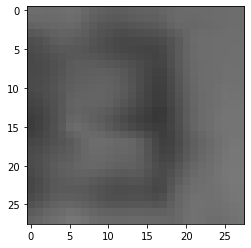

In [12]:
plt.imshow(X[4].permute(1,2,0))

# Weight soure samples

## Step 1: Train a domain classifier

In [13]:
batch_size = 16
transform = Compose([Resize((28,28)), ToTensor()])

source_dataset = MNIST('../datasets/',train=True, download = True, transform=transform)
n = int(0.8*len(source_dataset))
source_train, source_val = torch.utils.data.random_split(source_dataset, [n, len(source_dataset) - n])

source_loader = dict()
source_loader['train'] = DataLoader(source_train, batch_size=batch_size, shuffle=True)
source_loader['test'] = DataLoader(source_val, batch_size=batch_size, shuffle=True)


target_dataset = SVHN('../datasets/','train', download = True, transform=transform)
n = int(0.8*len(target_dataset))
target_train, target_val = torch.utils.data.random_split(target_dataset, [n, len(target_dataset) - n])


target_loader = dict()
target_loader['train'] = DataLoader(target_train, batch_size=batch_size, shuffle=True)
target_loader['test'] = DataLoader(target_val, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: ../datasets/train_32x32.mat


In [14]:
# Classifier should not be too good (fewer epochs, smaller LR, add regularization, linear classifier, etc.)
epochs = 2
domain_classifier = VisionNet(num_classes = 2)

criteria = nn.CrossEntropyLoss(reduce='sum')
optimizer = torch.optim.SGD(domain_classifier.parameters(), lr = 1e-4, momentum=0.9)

print('### Train Domain Classifier ###')
for epoch in range(epochs):
    domain_classifier.train()
    running_loss, corrects, count = 0.0, 0, 0
    for (Xs,_), (Xt,_) in zip(source_loader['train'], target_loader['train']):
        ys = torch.zeros(Xs.shape[0]).long()
        yt = torch.ones(Xt.shape[0]).long()
        X, y = torch.cat([Xs.repeat(1,3,1,1),Xt]), torch.cat([ys,yt])
        idx = torch.randperm(X.shape[0])
        X,y = X[idx],y[idx]
        
        preds = domain_classifier(X)
        loss = criteria(preds, y)
        running_loss += loss.item()
        corrects += get_corrects(preds, y)
        count += X.shape[0]
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    msg = 'Epoch: %d, Source Train Loss: %0.2f, Acc: %0.2f' % (epoch, running_loss/count, corrects/count)
    
    domain_classifier.eval()
    running_loss, corrects, count = 0.0, 0, 0
    for (Xs,_), (Xt,_) in zip(source_loader['test'], target_loader['test']):
        ys = torch.zeros(Xs.shape[0]).long()
        yt = torch.ones(Xt.shape[0]).long()
        X, y = torch.cat([Xs.repeat(1,3,1,1),Xt]), torch.cat([ys,yt])
        idx = torch.randperm(X.shape[0])
        X,y = X[idx],y[idx]
        
        with torch.no_grad():
            preds = domain_classifier(X)
            loss = criteria(preds, y)
            running_loss += loss.item()
            corrects += get_corrects(preds, y)
            count += X.shape[0]
    msg += ' Val Loss %0.2f, Acc: %0.2f' % (running_loss/count, corrects/count)
    print(msg)

### Train Domain Classifier ###
Epoch: 0, Source Train Loss: 0.00, Acc: 1.00 Val Loss 0.00, Acc: 1.00
Epoch: 1, Source Train Loss: 0.00, Acc: 1.00 Val Loss 0.00, Acc: 1.00


## Step 2: Train a weighted source classifier

In [15]:
# Redefine loaders
batch_size = 16
transform = Compose([Resize((28,28)), ToTensor()])

source_loader = dict()
source_loader['train'] = DataLoader(MNIST('../datasets/',train=True, download = True, transform=transform), 
                                    batch_size=batch_size, shuffle=True)
source_loader['test'] = DataLoader(MNIST('../datasets/',train=False, download = True, transform=transform),
                                   batch_size=batch_size, shuffle=True)

target_loader = dict()
target_loader['train'] = DataLoader(SVHN('../datasets/', 'train', download = True, transform=transform),
                                    batch_size=batch_size, shuffle=True)
target_loader['test'] = DataLoader(SVHN('../datasets/','test', download = True, transform=transform),
                                   batch_size=batch_size, shuffle=True)

Using downloaded and verified file: ../datasets/train_32x32.mat
Using downloaded and verified file: ../datasets/test_32x32.mat


In [16]:
model = VisionNet(num_classes = 10)
domain_classifier.eval()

epochs = 10

criteria = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9)
sm = nn.Softmax(1)

for epoch in range(epochs):
    model.train()
    running_loss, corrects, count = 0.0, 0, 0
    for X,y in source_loader['train']:
        preds = model(X)
        with torch.no_grad():
            sample_weight = domain_classifier(X)
        loss = criteria(preds, y)
        loss = loss * sm(sample_weight)[:,1]
        loss = loss.sum()
        running_loss += loss.item()
        corrects += get_corrects(preds, y)
        count += X.shape[0]
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    msg = 'Epoch: %d, Source Train Loss: %0.2f, Acc: %0.2f' % (epoch, running_loss/count, corrects/count)
    
    model.eval()
    running_loss, corrects, count = 0.0, 0, 0
    for X,y in source_loader['test']:
        with torch.no_grad():
            preds = model(X)
            loss = criteria(preds, y)
            running_loss += loss.sum().item()
            corrects += get_corrects(preds, y)
            count += X.shape[0]
    msg += ' Val Loss %0.2f, Acc: %0.2f' % (running_loss/count, corrects/count)
    

    model.eval()
    running_loss, corrects, count = 0.0, 0, 0
    for X,y in target_loader['test']:
        with torch.no_grad():
            preds = model(X)
            loss = criteria(preds, y)
            running_loss += loss.sum().item()
            corrects += get_corrects(preds, y)
            count += X.shape[0]
    accs['Weight Source'].append(corrects/count)
    print('%s Target Val Loss %0.2f, Acc %0.2f' % (msg, running_loss/count, corrects/count))
    

Epoch: 0, Source Train Loss: 0.00, Acc: 0.50 Val Loss 1.07, Acc: 0.72 Target Val Loss 2.39, Acc 0.17
Epoch: 1, Source Train Loss: 0.00, Acc: 0.75 Val Loss 0.77, Acc: 0.79 Target Val Loss 2.42, Acc 0.17
Epoch: 2, Source Train Loss: 0.00, Acc: 0.85 Val Loss 0.43, Acc: 0.90 Target Val Loss 2.67, Acc 0.14
Epoch: 3, Source Train Loss: 0.00, Acc: 0.90 Val Loss 0.35, Acc: 0.92 Target Val Loss 2.77, Acc 0.13
Epoch: 4, Source Train Loss: 0.00, Acc: 0.92 Val Loss 0.30, Acc: 0.93 Target Val Loss 2.82, Acc 0.13
Epoch: 5, Source Train Loss: 0.00, Acc: 0.93 Val Loss 0.26, Acc: 0.93 Target Val Loss 2.88, Acc 0.13
Epoch: 6, Source Train Loss: 0.00, Acc: 0.93 Val Loss 0.23, Acc: 0.94 Target Val Loss 2.93, Acc 0.13
Epoch: 7, Source Train Loss: 0.00, Acc: 0.94 Val Loss 0.22, Acc: 0.94 Target Val Loss 2.93, Acc 0.13
Epoch: 8, Source Train Loss: 0.00, Acc: 0.94 Val Loss 0.20, Acc: 0.95 Target Val Loss 3.00, Acc 0.12
Epoch: 9, Source Train Loss: 0.00, Acc: 0.95 Val Loss 0.19, Acc: 0.95 Target Val Loss 3.01,

# SSL

# Comparison

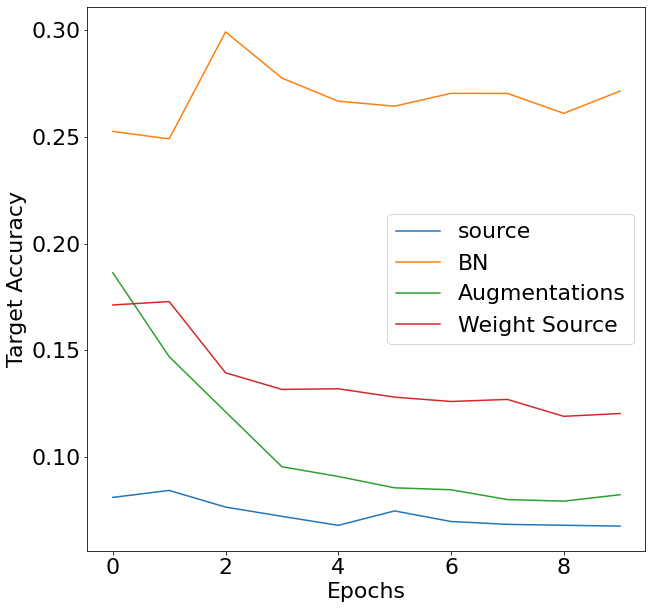

In [17]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,10))
for k,v in accs.items():
    plt.plot(v, label=k)

plt.ylabel("Target Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()
